<a href="https://colab.research.google.com/github/paul6598/AI_practice/blob/main/240420.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data #데이터셋 api command

Saving kaggle.json to kaggle.json
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 23.4MB/s]


In [ ]:
!unzip -o /content/daily-climate-time-series-data.zip -d /content/data_set

Archive:  /content/daily-climate-time-series-data.zip
  inflating: /content/data_set/DailyDelhiClimateTest.csv  
  inflating: /content/data_set/DailyDelhiClimateTrain.csv  


In [ ]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
"""
LSTM은 데이터 전처리가 필요하다.
단순히 시간순으로 정렬된 데이터를 원하는 timestep만큼 잘라서 한칸씩 내려오며 각 window를 모은 data를
input으로 사용해야 함. y값도 원하는 시점의 data를 잘라서 그걸 이용하면 됨.
생각보다 어렵다...ㅜ
"""

In [ ]:
train_data = pd.read_csv("/content/data_set/DailyDelhiClimateTrain.csv")
test_data = pd.read_csv("/content/data_set/DailyDelhiClimateTest.csv")

In [ ]:
print(train_data)
print(test_data)

            date   meantemp    humidity  wind_speed  meanpressure
0     2013-01-01  10.000000   84.500000    0.000000   1015.666667
1     2013-01-02   7.400000   92.000000    2.980000   1017.800000
2     2013-01-03   7.166667   87.000000    4.633333   1018.666667
3     2013-01-04   8.666667   71.333333    1.233333   1017.166667
4     2013-01-05   6.000000   86.833333    3.700000   1016.500000
...          ...        ...         ...         ...           ...
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 5 columns]
           date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   101

# 데이터 전처리

In [ ]:
train_data = train_data.drop("date",axis=1)
test_data = test_data.drop("date",axis=1)

In [ ]:
train_data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## 이상치 제거

In [ ]:
def remove_outlier(data, column): #이상치 제거 하는 함수, q1-1.5*IQR 미만 혹은 q3+1.5*IQR 초과인 값을 제거한다.
  q1 = data[column].quantile(0.25)
  q3 = data[column].quantile(0.75)
  iqr = q3-q1

  boundary = iqr*1.5
  index1 = data[data[column] > q3+boundary].index
  index2 = data[data[column] < q1-boundary].index

  data[column] = data[column].drop(index1)
  data[column] = data[column].drop(index2)

  return data

In [ ]:
for column in train_data:
  remove_outlier(train_data, column)

train_data

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
1457,17.217391,68.043478,3.547826,1015.565217
1458,15.238095,87.857143,6.000000,1016.904762
1459,14.095238,89.666667,6.266667,1017.904762
1460,15.052632,87.000000,7.325000,1016.100000


## 결측치 평균으로 대체

In [ ]:
for column in train_data:
  train_data[column] = train_data[column].fillna(train_data[column].mean())


## -1~1 사이의 값으로 정규화

In [ ]:
def min_max_scaling(data, column):
  range_ = data[column].max()-data[column].min()
  min_ = data[column].min()
  data[column] = 2*(data[column]-min_)/range_-1
  return data

def reverse_scaling(data, column, min_, max_):
  range_ = max_-min_
  data[column] = ((data[column]+1)/2)*range_ + min_
  return data

In [ ]:
test_min, test_max = test_data.min(), test_data.max()

In [ ]:
test_min

meantemp        11.0000
humidity        17.7500
wind_speed       1.3875
meanpressure    59.0000
dtype: float64

In [ ]:
for column in train_data:
  min_max_scaling(train_data, column)

In [ ]:
for column in test_data:
  min_max_scaling(test_data, column)

test_data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,-0.088249,-0.013660,-0.246220,0.961041
std,0.541283,0.488403,0.400300,0.185669
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.537260,-0.439701,-0.534100,0.968102
50%,-0.244681,0.024546,-0.254530,0.979103
75%,0.421733,0.387051,-0.031477,0.987404
max,1.000000,1.000000,1.000000,1.000000


# LSTM용 데이터 슬라이싱

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

predict = 1
train_step = 14
train_size = train_data.shape[0] #1462
test_size = test_data.shape[0] #114

In [ ]:
#train 데이터는 0~13 (y값 14) >>  1447~1460(y값 1461)

for i in range(train_size - train_step - predict): #1462-14-1 = 1447
  train_x.append(train_data.loc[i:i+train_step-1])
  train_y.append(train_data["meantemp"][i+train_step])

In [ ]:
for i in range(test_size - train_step - predict): #1462-14-1 = 1447
  test_x.append(test_data.loc[i:i+train_step-1])
  test_y.append(test_data["meantemp"][i+train_step])


In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [ ]:
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
print(test_x.shape)

(99, 14, 4)


In [ ]:
print(train_x.shape)
print(train_y.shape)

(1447, 14, 4)
(1447,)


# 모델 구성

In [ ]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape = (train_step,4), activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64,  activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 256)           267264    
                                                                 
 dropout_2 (Dropout)         (None, 14, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 349505 (1.33 MB)
Trainable params: 349505 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 모델 컴파일

In [ ]:
model.compile(optimizer="adam",loss="mae",metrics=["mean_squared_error"])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss",patience=20)

# 모델 학습

# 결과 시각화

In [ ]:
history = model.fit(train_x, train_y,
                    batch_size=30,
                    epochs = 1000,
                    verbose = 1,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
39/39 [==============================] - 9s 104ms/step - loss: 0.1461 - mean_squared_error: 0.0380 - val_loss: 0.1063 - val_mean_squared_error: 0.0176
Epoch 2/1000
39/39 [==============================] - 4s 104ms/step - loss: 0.1132 - mean_squared_error: 0.0207 - val_loss: 0.0942 - val_mean_squared_error: 0.0144
Epoch 3/1000
39/39 [==============================] - 3s 77ms/step - loss: 0.1061 - mean_squared_error: 0.0183 - val_loss: 0.1049 - val_mean_squared_error: 0.0172
Epoch 4/1000
39/39 [==============================] - 3s 78ms/step - loss: 0.1049 - mean_squared_error: 0.0181 - val_loss: 0.0937 - val_mean_squared_error: 0.0140
Epoch 5/1000
39/39 [==============================] - 3s 78ms/step - loss: 0.1016 - mean_squared_error: 0.0168 - val_loss: 0.0901 - val_mean_squared_error: 0.0130
Epoch 6/1000
39/39 [==============================] - 4s 102ms/step - loss: 0.1004 - mean_squared_error: 0.0165 - val_loss: 0.0917 - val_mean_squared_error: 0.0134
Epoch 7/1000
39/39 

In [79]:
pred_y = model.predict(test_x)
print(pred_y)

4/4 [==============================] - 1s 24ms/step
[[-0.75145125]
 [-0.50074244]
 [-0.6505529 ]
 [-0.8504891 ]
 [-0.76634896]
 [-0.6696763 ]
 [-0.63077044]
 [-0.6053226 ]
 [-0.36062875]
 [-0.38492146]
 [-0.339592  ]
 [-0.16149125]
 [-0.47718105]
 [-0.45945308]
 [-0.60988444]
 [-0.5277783 ]
 [-0.48645446]
 [-0.49189618]
 [-0.55367225]
 [-0.43701053]
 [-0.53878146]
 [-0.32939848]
 [-0.35418245]
 [-0.46510437]
 [-0.5990682 ]
 [-0.54893935]
 [-0.5861767 ]
 [-0.6281933 ]
 [-0.56741536]
 [-0.50704867]
 [-0.51268363]
 [-0.4734994 ]
 [-0.4232668 ]
 [-0.2438834 ]
 [-0.1528873 ]
 [-0.14015225]
 [-0.04938691]
 [ 0.02197786]
 [-0.06610192]
 [-0.23518252]
 [-0.28850797]
 [-0.25084403]
 [-0.23786837]
 [-0.24054143]
 [-0.15603018]
 [ 0.07511777]
 [ 0.15119994]
 [ 0.12162951]
 [-0.10047981]
 [-0.21373716]
 [-0.19582278]
 [-0.17621966]
 [ 0.0066735 ]
 [-0.05069066]
 [-0.08343254]
 [-0.15788886]
 [-0.25703442]
 [-0.35504854]
 [-0.37179437]
 [-0.32968822]
 [-0.21064928]
 [ 0.07046701]
 [-0.11839685]
 [ 

In [80]:
pred_y = pred_y.reshape(1,pred_y.shape[0])

In [81]:
pred_y = list(pred_y[0])

In [82]:
pred_y

[-0.75145125,
 -0.50074244,
 -0.6505529,
 -0.8504891,
 -0.76634896,
 -0.6696763,
 -0.63077044,
 -0.6053226,
 -0.36062875,
 -0.38492146,
 -0.339592,
 -0.16149125,
 -0.47718105,
 -0.45945308,
 -0.60988444,
 -0.5277783,
 -0.48645446,
 -0.49189618,
 -0.55367225,
 -0.43701053,
 -0.53878146,
 -0.32939848,
 -0.35418245,
 -0.46510437,
 -0.5990682,
 -0.54893935,
 -0.5861767,
 -0.6281933,
 -0.56741536,
 -0.50704867,
 -0.51268363,
 -0.4734994,
 -0.4232668,
 -0.2438834,
 -0.1528873,
 -0.14015225,
 -0.049386915,
 0.02197786,
 -0.06610192,
 -0.23518252,
 -0.28850797,
 -0.25084403,
 -0.23786837,
 -0.24054143,
 -0.15603018,
 0.07511777,
 0.15119994,
 0.12162951,
 -0.10047981,
 -0.21373716,
 -0.19582278,
 -0.17621966,
 0.0066735037,
 -0.050690662,
 -0.08343254,
 -0.15788886,
 -0.25703442,
 -0.35504854,
 -0.37179437,
 -0.32968822,
 -0.21064928,
 0.07046701,
 -0.11839685,
 0.14422782,
 0.14288436,
 0.08199848,
 0.19039944,
 0.33829448,
 0.41848722,
 0.46215537,
 0.35484758,
 0.4959378,
 0.5649392,
 0.611

In [83]:
test_y = list(test_y)
print(test_y)

[-0.5374653098982424, -0.6893617021276596, -0.9385342789598111, -0.8262411347517731, -0.6919959473150961, -0.6371780515117581, -0.6262719703977797, -0.3668085106382978, -0.39424280350438046, -0.3746530989824236, -0.14893617021276595, -0.5592705167173253, -0.5319148936170213, -0.6711798839458414, -0.6028368794326242, -0.5366430260047282, -0.5638297872340425, -0.6382978723404256, -0.481624758220503, -0.6054158607350096, -0.34468085106382984, -0.3505039193729004, -0.49881796690307323, -0.648936170212766, -0.6000000000000001, -0.6276595744680851, -0.6879432624113475, -0.6063829787234043, -0.5531914893617021, -0.546099290780142, -0.5, -0.4407294832826747, -0.21276595744680848, -0.12340425531914889, -0.13829787234042556, -0.03288201160541593, 0.05319148936170204, -0.07801418439716357, -0.3085106382978723, -0.35106382978723405, -0.3085106382978723, -0.3191489361702128, -0.34042553191489366, -0.24468085106382975, 0.0496453900709215, 0.1456628477905073, 0.0851063829787233, -0.19148936170212771,

In [84]:
predict = []
real = []
range_ = test_max[0] - test_min[0]
for i in range(99):
  predict.append(((pred_y[i]+1)/2)*range_ + test_min[0])
  real.append(((test_y[i]+1)/2)*range_ + test_min[0])
  if i%10 == 0:
    print(((pred_y[i]+1)/2)*range_ + test_min[0])

13.920447766780853
18.759793885052204
16.419317796826363
16.725967347621918
19.360031373798847
20.449082389473915
20.274870939552784
26.91945906728506
30.525706991553307
30.414850667119026


In [ ]:
pred_y = []
real_y = []
test_len = test_x.shape[0]
for i in range(test_len):
  pred_y.append(model.predict(np.array([test_x[i]]))[0][0])
  real_y.append(test_y[i])
  #history = model.fit(np.array([test_x[i]]), np.array([test_y[i]]),
  #                  epochs = 1,
  #                  verbose = 1,)



1/1 [==============================] - 0s 41ms/step


실제 기온:  16.4348 예측 기온:  13.9204 오차율:  15.2989 %
실제 기온:  14.65 예측 기온:  16.8663 오차율:  15.1282 %
실제 기온:  11.7222 예측 기온:  15.106 오차율:  28.8664 %
실제 기온:  13.0417 예측 기온:  12.7568 오차율:  2.1846 %
실제 기온:  14.619 예측 기온:  13.7454 오차율:  5.9761 %
실제 기온:  15.2632 예측 기온:  14.8813 오차율:  2.5018 %
실제 기온:  15.3913 예측 기온:  15.3384 오차율:  0.3434 %
실제 기온:  18.44 예측 기온:  15.6375 오차율:  15.1982 %
실제 기온:  18.1176 예측 기온:  18.5126 오차율:  2.18 %
실제 기온:  18.3478 예측 기온:  18.2272 오차율:  0.6576 %
실제 기온:  21.0 예측 기온:  18.7598 오차율:  10.6676 %
실제 기온:  16.1786 예측 기온:  20.8525 오차율:  28.8895 %
실제 기온:  16.5 예측 기온:  17.1431 오차율:  3.8977 %
실제 기온:  14.8636 예측 기온:  17.3514 오차율:  16.7374 %
실제 기온:  15.6667 예측 기온:  15.5839 오차율:  0.5286 %
실제 기온:  16.4444 예측 기온:  16.5486 오차율:  0.6334 %
실제 기온:  16.125 예측 기온:  17.0342 오차율:  5.6382 %
실제 기온:  15.25 예측 기온:  16.9702 오차율:  11.2801 %
실제 기온:  17.0909 예측 기온:  16.2444 오차율:  4.9533 %
실제 기온:  15.6364 예측 기온:  17.6151 오차율:  12.6549 %
실제 기온:  18.7 예측 기온:  16.4193 오차율:  12.1962 %
실제 기온:  18.6316 예측 기온: 

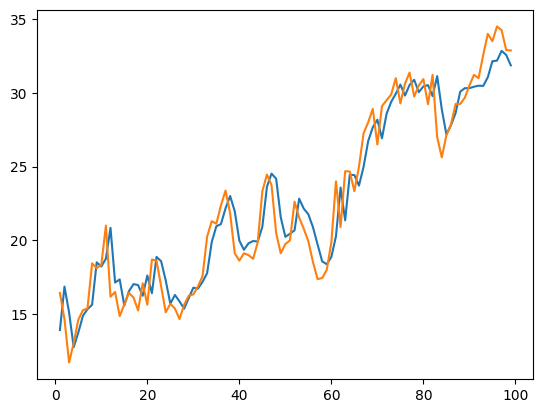

In [85]:
x_num = []
for i in range(99):
  print("실제 기온: ",round(real[i],4), "예측 기온: ", round(predict[i],4), "오차율: ",round(100*(abs((real[i]-predict[i])/real[i])),4),"%")
  x_num.append(i+1)

plt.plot(x_num, predict, label="predict")
plt.plot(x_num, real, label="real")

In [86]:
model2 = clone_model(model)

In [ ]:
model2.compile(optimizer="adam",loss="mae",metrics=["mean_squared_error"])

In [ ]:
pred_y2 = []
real_y2 = []
test_len = test_x.shape[0]
for i in range(test_len):
  pred_y2.append(model2.predict(np.array([test_x[i]]))[0][0])
  real_y2.append(test_y[i])
  history = model2.fit(np.array([test_x[i]]), np.array([test_y[i]]),
                    epochs = 1,
                    verbose = 1,)


1/1 [==============================] - 0s 20ms/step - loss: 0.0404 - mean_squared_error: 0.0016


실제 기온:  -0.5375 예측 기온:  0.0498 오차율:  109.2724 %
실제 기온:  -0.6894 예측 기온:  -0.1482 오차율:  78.4973 %
실제 기온:  -0.9385 예측 기온:  -0.3381 오차율:  63.9743 %
실제 기온:  -0.8262 예측 기온:  -0.5421 오차율:  34.3871 %
실제 기온:  -0.692 예측 기온:  -0.7771 오차율:  12.3018 %
실제 기온:  -0.6372 예측 기온:  -1.031 오차율:  61.7998 %
실제 기온:  -0.6263 예측 기온:  -1.169 오차율:  86.6664 %
실제 기온:  -0.3668 예측 기온:  -1.1821 오차율:  222.2747 %
실제 기온:  -0.3942 예측 기온:  -1.1081 오차율:  181.0582 %
실제 기온:  -0.3747 예측 기온:  -1.006 오차율:  168.5069 %
실제 기온:  -0.1489 예측 기온:  -0.893 오차율:  499.5619 %
실제 기온:  -0.5593 예측 기온:  -0.7737 오차율:  38.3463 %
실제 기온:  -0.5319 예측 기온:  -0.6563 오차율:  23.3878 %
실제 기온:  -0.6712 예측 기온:  -0.5792 오차율:  13.7002 %
실제 기온:  -0.6028 예측 기온:  -0.4957 오차율:  17.7677 %
실제 기온:  -0.5366 예측 기온:  -0.4455 오차율:  16.9817 %
실제 기온:  -0.5638 예측 기온:  -0.399 오차율:  29.2363 %
실제 기온:  -0.6383 예측 기온:  -0.3802 오차율:  40.4381 %
실제 기온:  -0.4816 예측 기온:  -0.3834 오차율:  20.3902 %
실제 기온:  -0.6054 예측 기온:  -0.4039 오차율:  33.289 %
실제 기온:  -0.3447 예측 기온:  -0.4377 오차율:  26.97

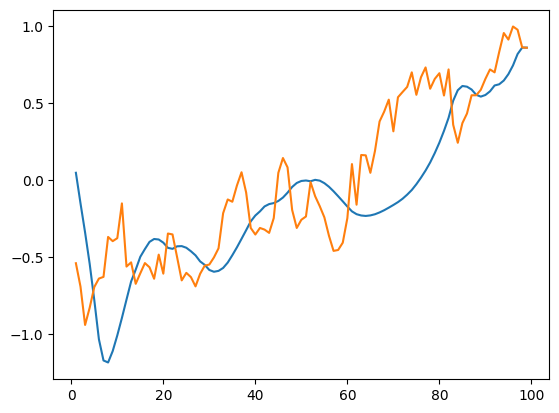

In [ ]:
x_num = []
for i in range(99):
  print("실제 기온: ",round(real_y2[i],4), "예측 기온: ", round(pred_y2[i],4), "오차율: ",round(100*(abs((real_y2[i]-pred_y2[i])/real_y2[i])),4),"%")
  x_num.append(i+1)

plt.plot(x_num, pred_y2, label="predict")
plt.plot(x_num, real_y2, label="real")